In [354]:
import os
from glob import glob
import json
import math

from matplotlib import pyplot as plt
import numpy as np

import cv2 as cv
import scipy
from skimage import measure, draw, filters

In [355]:
image_folder = '/home/meso/data/cross-section-photos/analysis/photos'
centres_json_ffn = '/home/meso/data/cross-section-photos/analysis/photos/stones01-05.json'

In [ ]:
def remove_edge_peak(lum_data, peaks, limit=50):
    
    #define edge
    edge_idx = np.where(lum_data>0)[0][-1]
    #check if last peak is within the limit of the edge
    if (edge_idx - peaks[-1]) < limit:
        return peaks[:-1]
    else:
        return peaks

def find_peak_width(lum_data, peaks, fall_perc = 0.20, merge_dist=15):
    
    left_pass_1 = []
    right_pass_1 = []
    centre_list = []
    for peak_idx in peaks:
        #extract peak lumosity
        peak_lum = lum_data[peak_idx]
        #extract threshold for lumosity
        peak_lower_limit = peak_lum - (peak_lum*fall_perc)
        #setup arrays for detecting edges of dry growth region
        lum_data_left = lum_data.copy()
        lum_data_left[peak_idx:] = peak_lum #replace lum values on the right side of the peak with peak_lum, preserving the left side
        lum_data_right = lum_data.copy()
        lum_data_right[:peak_idx] = peak_lum #replace lum values on the left side of the peak with peak_lum, preserving the right side
        #find peaks
        peak_right = np.where(lum_data_right<peak_lower_limit)[0][0] #use first value below the threshold to find the right point. Will always work because of background
        try:
            peak_left = np.where(lum_data_left<peak_lower_limit)[0][-1] #use last value below threshold to find left point
        except:
            #cases for close peaks to centre, and transect does not reduce below threshold.
            peak_left = peak_idx - (peak_right-peak_idx) #reflection of right peak
        left_pass_1.append(peak_left)
        right_pass_1.append(peak_right)

    left_pass_1  = np.array(left_pass_1)
    right_pass_1 = np.array(right_pass_1)
    centre_pass_1 = np.array((left_pass_1+right_pass_1)/2).astype(int)
    
    #merge overlapping peaks or very close peaks
    left_pass_2 = []
    right_pass_2 = []
    proc_flag = np.zeros_like(left_pass_1, dtype=bool)
    for i, centre in enumerate(centre_pass_1):
        #check if already processes
        if proc_flag[i]:
            continue
        #find if centre overlaps with multiple left/right regions
        overlap = np.where(np.logical_and(left_pass_1<centre, right_pass_1>centre))[0]
        #find if any right/left points are very close
        close = np.where(np.logical_or(np.abs(left_pass_1[i]-right_pass_1)<merge_dist, np.abs(right_pass_1[i]-left_pass_1)<merge_dist))[0]
        #combine
        merge = np.unique(np.append(overlap, close))
        #find min of those points
        left_pass_2.append(np.min(left_pass_1[merge]))
        right_pass_2.append(np.max(right_pass_1[merge]))
        #assign as processed
        proc_flag[merge] = True
    
    #output
    left_array  = np.array(left_pass_2)
    right_array  = np.array(right_pass_2)
    centre_array = np.array((left_array+right_array)/2).astype(int)
    return centre_array, left_array, right_array

In [ ]:
def generate_layers(azi_array, cidx_array, width_list):
    
    #work in coordinates of transect index (x) and centre index (y)
    #for point (i), find two nearest points, create group if max dist < A pixels and width difference < B%

In [494]:



def worker(image_ffn, cx, cy):

    #transform into hsv colorspace
    img_data = cv.imread(image_ffn)
    img_data_hls = cv.cvtColor(img_data, cv.COLOR_BGR2HLS)
    lum_img = img_data_hls[:,:,1]
    img_size = np.shape(lum_img)
    lum_img_smooth = filters.gaussian(lum_img, sigma=4)*255

    #plot initial image
    fig = plt.figure(facecolor='white',figsize=[20, 20])
    plt.subplot(221)
    plt.gca().invert_yaxis()
    plt.imshow(lum_img)
    plt.plot(cx, cy, 'r*')
    
    #define and plot transect lines
    extract_range   = 500 #pixels
    azimuth_spacing = 5 #degrees
    #init azimuth list
    azimuth_list    = np.arange(0,360,azimuth_spacing)
    
    line_x_list = []
    line_y_list = []
    line_lum_list = []
    peaks_idx_list = []
    cl_x_list = []
    cl_y_list = []
    cr_x_list = []
    cr_y_list = []
    c_width_list = []
    c_idx_list = []
    c_x_list = []
    c_y_list = []
    c_azi_list = []
    #for each azimuth
    for azi in azimuth_list:
        # create indicies for lines from centroid along search azimuth rays
        end_x    = int(cx + extract_range*math.cos(math.radians(azi)))
        end_y    = int(cy + extract_range*math.sin(math.radians(azi)))
        #enforce boundaries
        if end_x < 0:
            end_x = 0
        elif end_x > img_size[1]-1:
            end_x = img_size[1]-1
        if end_y < 0:
            end_y = 0
        elif end_y > img_size[0]-1:
            end_y = img_size[0]-1
        #generate line points
        line_y, line_x = draw.line(cy, cx, end_y, end_x)
        # extract data along 
        line_lum = lum_img_smooth[line_y, line_x].astype(int)
        #measure peaks
        peaks_idx, _ = scipy.signal.find_peaks(line_lum, prominence=30, distance=30, height=100)
        #remove edge peaks
        peaks_idx = remove_edge_peak(line_lum, peaks_idx)
        #find width of peaks
        centre_idx, left_idx, right_idx = find_peak_width(line_lum, peaks_idx)
        
        #store
        line_x_list.append(line_x)
        line_y_list.append(line_y)
        line_lum_list.append(line_lum)
        peaks_idx_list.append(peaks_idx)
        cl_x_list.append(line_x[left_idx])
        cl_y_list.append(line_y[left_idx])
        cr_x_list.append(line_x[right_idx])
        cr_y_list.append(line_y[right_idx])
        c_width_list.append(right_idx-left_idx)
        c_idx_list.append(centre_idx)
        c_x_list.append(line_x[centre_idx])
        c_y_list.append(line_y[centre_idx])
        c_azi_list.append(np.zeros_like(centre_idx)+azi)
        
    #flatten centre info arrays
    cl_x_array = np.concatenate(cl_x_list).ravel()
    cl_y_array = np.concatenate(cl_y_list).ravel()
    cr_x_array = np.concatenate(cr_x_list).ravel()
    cr_y_array = np.concatenate(cr_y_list).ravel()    
    c_width_list = np.concatenate(c_width_list).ravel()    
    c_idx_array = np.concatenate(c_idx_list).ravel()
    c_x_array = np.concatenate(c_x_list).ravel()
    c_y_array = np.concatenate(c_y_list).ravel()
    c_azi_array = np.concatenate(c_azi_list).ravel()
    
    #generate layers
    layers_array = generate_layers(c_azi_array, c_idx_array, c_width_list)
    
    #plot luminosity data on x,y axis
    plt.subplot(222)
    for i, lum_data in enumerate(line_lum_list):
        x_data = np.arange(len(lum_data))
        peaks = peaks_idx_list[i]
        plt.plot(x_data, lum_data, 'r-')
        plt.plot(peaks, lum_data[peaks], "bo")
        
    #plot azimuth data on image
    plt.subplot(223)
    plt.gca().invert_yaxis()
    plt.imshow(lum_img_smooth)
    for i, _ in enumerate(cl_x_array):
        #mark peaks
        plt.plot(c_x_array[i], c_y_array[i], 'b.')
        #mark edges
        plt.plot([cl_x_array[i],cr_x_array[i]],[cl_y_array[i],cr_y_array[i]], 'r-')        
        
    #plot azimuth data on image
    plt.subplot(224)
    #mark peaks
    plt.plot(c_azi_array, c_idx_array, 'bo')
    

In [495]:
#build image file and centroid arguments from json
image_args_list = []
with open(centres_json_ffn) as json_fh:  
    data = json.load(json_fh)
    for item in data.keys():
        img_fn = data[item]['filename']
        cx = data[item]['regions'][0]['shape_attributes']['cx']
        cy = data[item]['regions'][0]['shape_attributes']['cy']
        image_args_list.append((f'{image_folder}/{img_fn}', cx, cy))

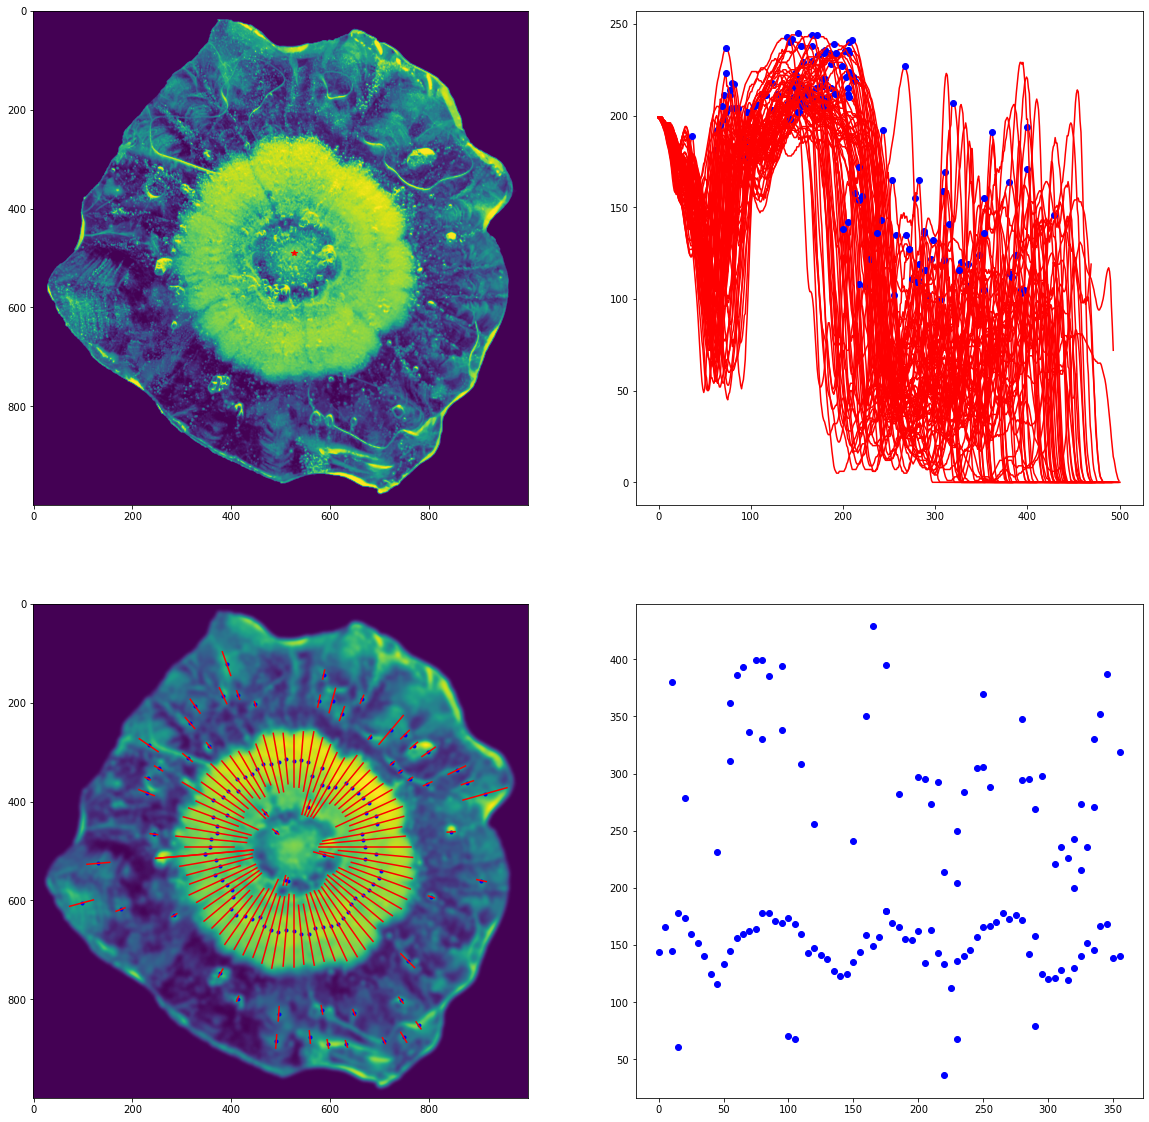

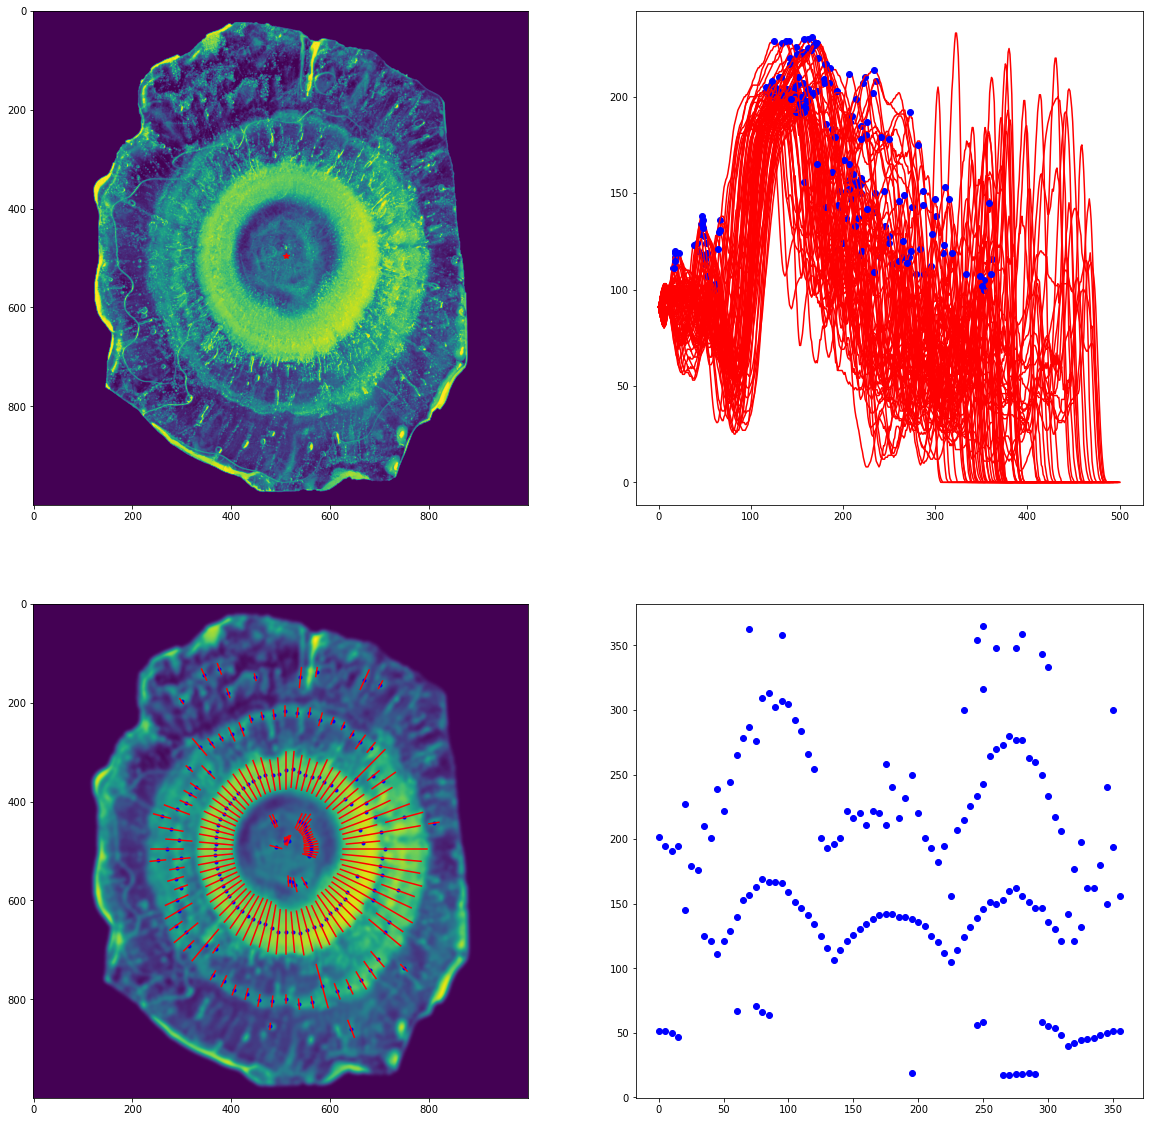

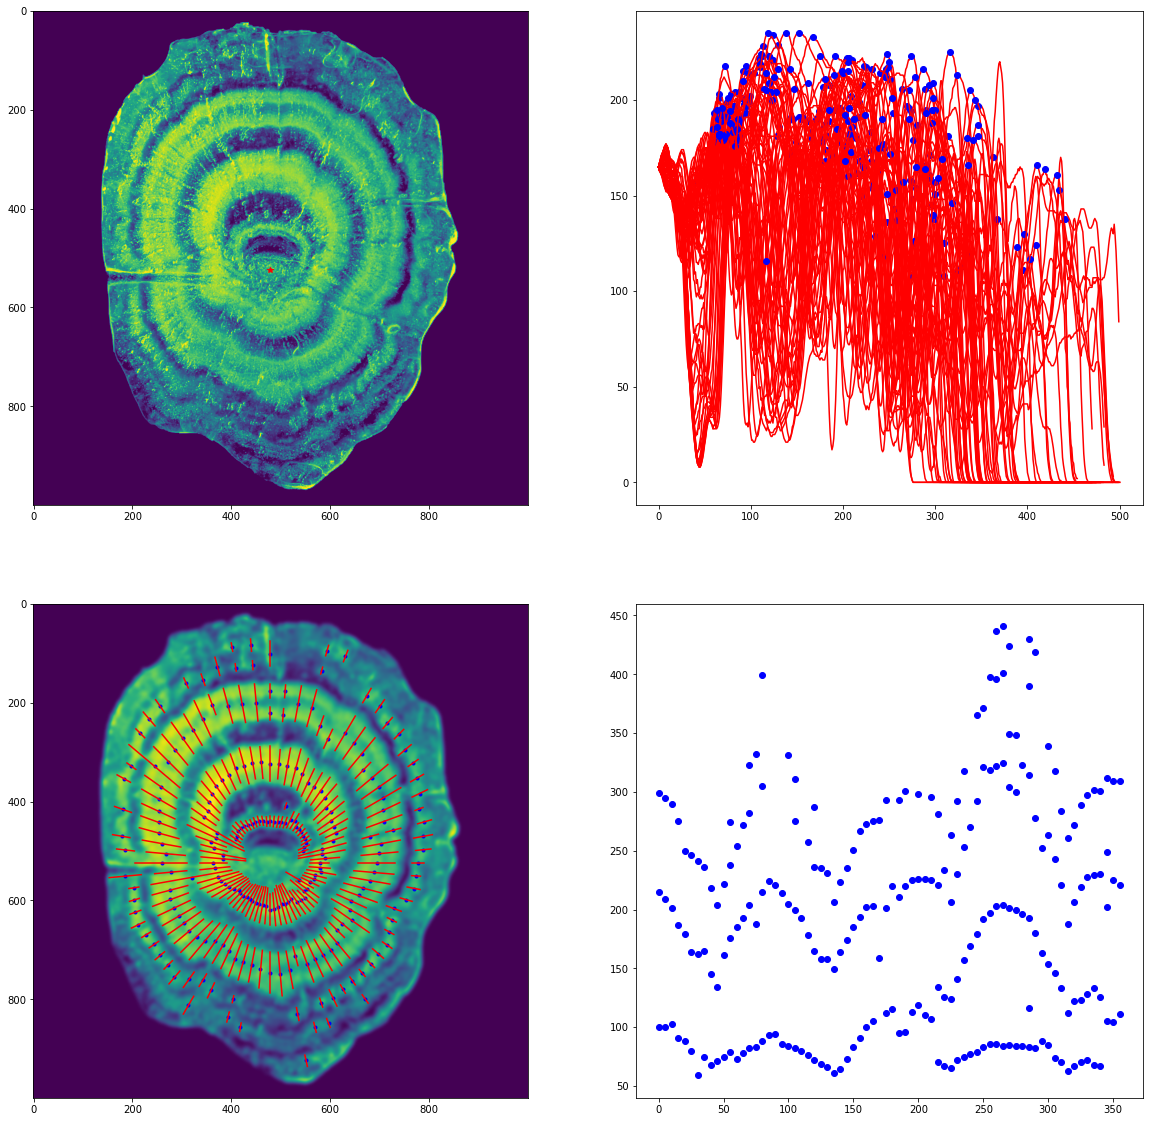

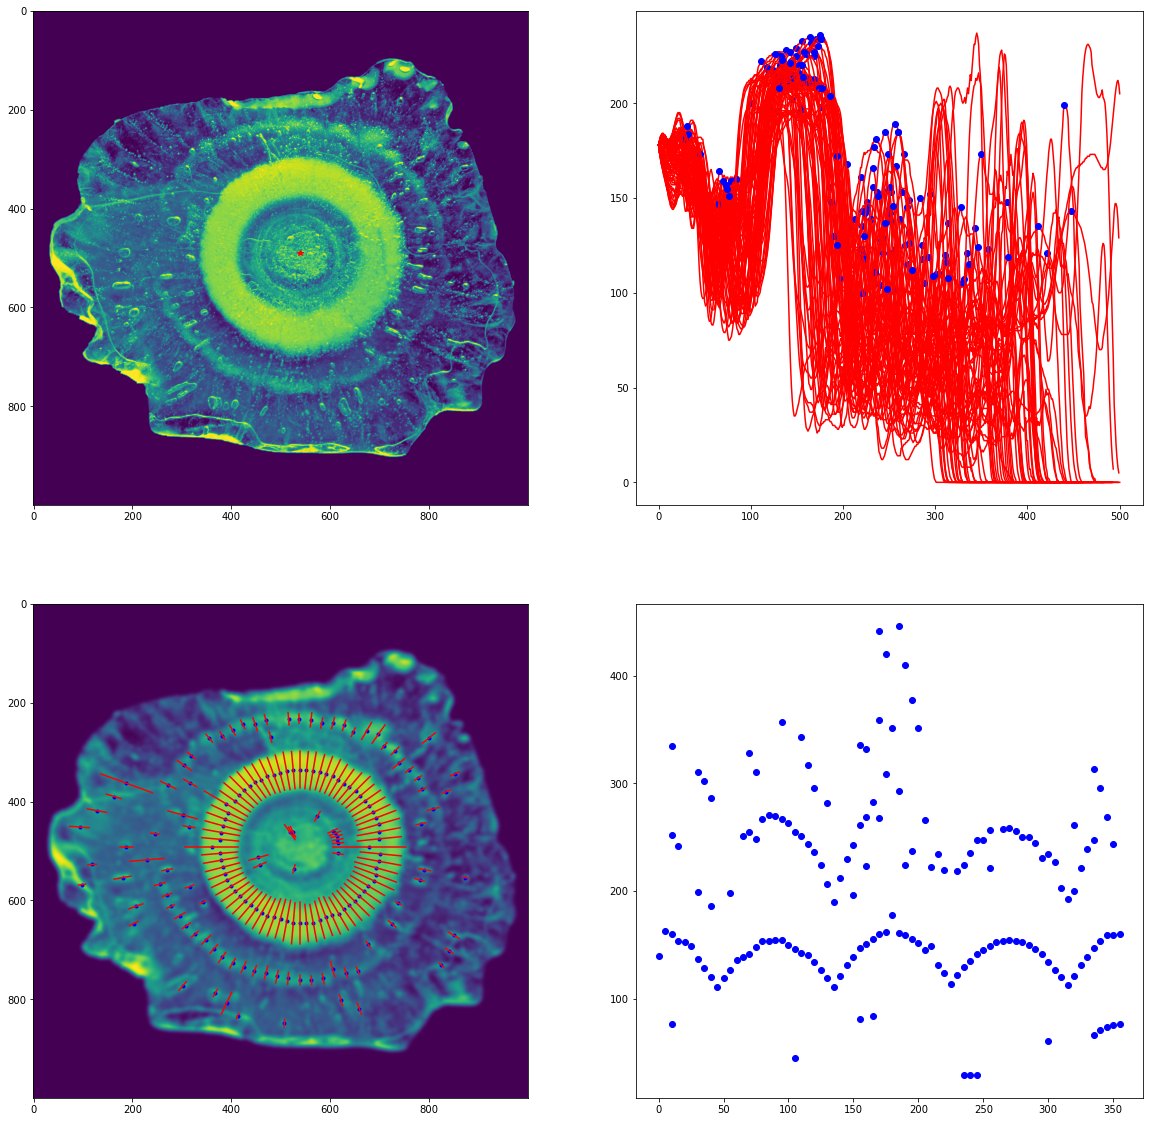

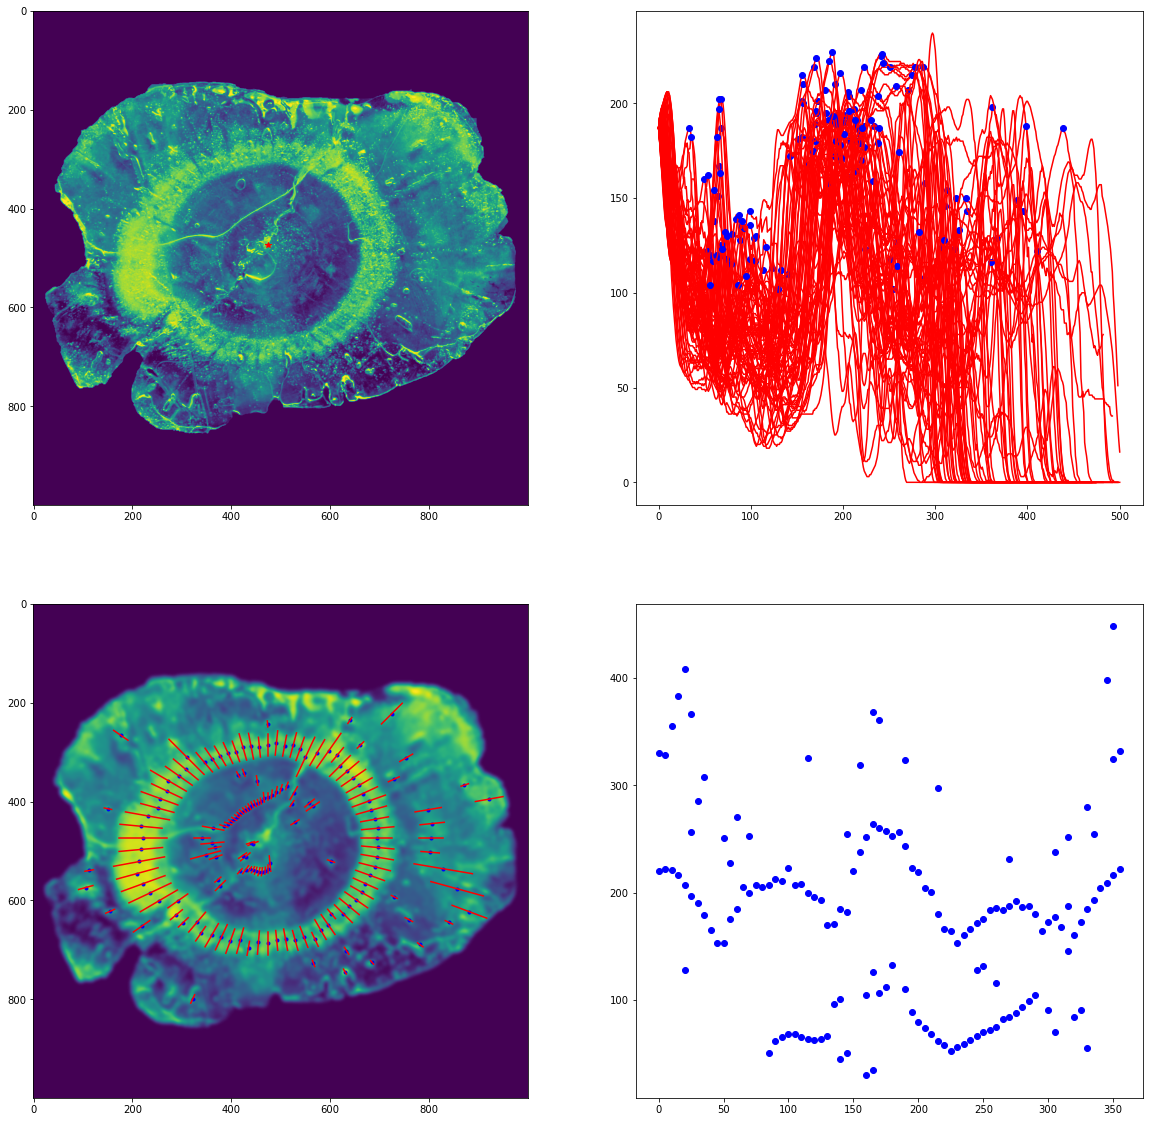

In [496]:
for item in image_args_list[0:]:
    worker(*item)
    #break


In [483]:
print(np.concatenate(input_list).ravel()

[array([1, 2, 3]) array([4, 6])]


<ipython-input-483-db856020b9ad>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array([np.array([1,2,3]), np.array([4,6])]))
